In [1]:
import numpy as np
import scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.optimize import minimize
import cvxopt
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('C:/Users/LMatt/OneDrive/Dokumente/Mathe/Machine Learning/Projekt/digits_train.csv')

In [3]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,28**2)]
train_images = np.array(train[images], dtype=np.float)/100
#dimensionserhoehung, damit am ende b = 0
train_images = np.concatenate((train_images, np.ones((len(train_images),1))), axis = 1)

train_labels = np.array(train['label'])
label0 = np.array([1 if i==0 else -1 for i in train_labels])
len(train_images)

42000

In [4]:
#mal gucken, wie weit die Datenpunkte so ungefähr auseinander liegen, damit wir wissen wie groß sigma sein muss
np.linalg.norm(train_images[130] - train_images[6])

28.478958899510353

In [5]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-sigma*np.linalg.norm(x1-x2)**2)

def gk(x1,x2):
    sigma = float(1)/100
    return gaussian_kernel(x1, x2, sigma)

def scalar_product(x1, x2):
    return np.dot(x1, x2)

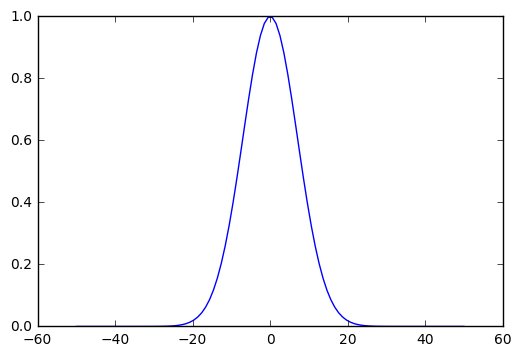

In [6]:
plt.figure()
x = np.linspace(-50, 50, 100)
y = [gk(0,i) for i in x]
plt.plot(x, y)

In [7]:
def minimize_Lagrangian(training_data, training_labels, penalty, kernel):
    no_samples = len(training_data)
    t = np.diag(training_labels[:no_samples])
    tm = -t
    K = matrix(pairwise_kernels(training_data, metric = kernel),tc='d')
    p = matrix(training_labels,tc='d')
    A = matrix(1., ( 1,no_samples),tc='d')
    b = matrix(0.,(1,1),tc='d')
    G = matrix(np.concatenate((tm,t)),tc='d')
    h = matrix(np.concatenate((matrix(0.,(no_samples,1 )), matrix(float(penalty),(no_samples,1)))),tc='d')
    sol = solvers.qp(-K, p, G, h, A, b)
    x = np.reshape(np.array(sol['x']), no_samples)
    a = np.array([x[i]*training_labels[i] for i in range(no_samples)])
    return a

In [8]:
def assemble_kernelmatrix(data, data2 = None, kernel = scalar_product):
    if data2 == None:
        K = pairwise_kernels(data, metric = kernel)
    else:
        K = pairwise_kernels(data2, data, metric = kernel)
    return K

def minimize_Lagrangian2(training_data, training_labels, penalty, kernel, kernelmatrix):
    no_samples = len(training_data)
    training_labels = matrix(training_labels, (no_samples, 1))
    K = kernelmatrix
    T = np.dot(training_labels, np.transpose(training_labels))
    Q = matrix(np.multiply(K, T), (no_samples, no_samples), tc='d')
    A = matrix(training_labels, ( 1, no_samples),tc='d')
    print(np.shape(A))
    p = matrix(-1., ( no_samples, 1),tc='d')
    b = matrix(0.,(1,1),tc='d')
    G = matrix(np.concatenate((-np.identity(no_samples),np.identity(no_samples))),tc='d')
    h = matrix(np.concatenate((matrix(0.,(no_samples,1 )), matrix(float(penalty),(no_samples,1)))),tc='d')
    sol = solvers.qp(Q, p, G, h, A, b)
    a = np.reshape(np.array(sol['x']), no_samples)
    return a 

In [9]:
def minimize_Lagrangian3(training_data, training_labels, penalty, kernel):

    no_samples = len(training_data)
    K = pairwise_kernels(training_data, metric = kernel)
    def Lagrangian(x):
        return 0.5*np.dot(np.dot(np.transpose(x),Q),x) - np.dot(np.transpose(p),x)
    T = np.dot(training_labels, np.transpose(training_labels))
    Q = np.multiply(K, T)
    A = training_labels
    p = np.ones(no_samples)
    b = np.array(0.)
    G = np.concatenate((-np.identity(no_samples),np.identity(no_samples)))
    h = np.concatenate((np.zeros(no_samples), penalty*np.ones(no_samples)))
    '''K = np.array(K)
    q = np.array(q)
    A = np.array(A)
    b = np.array(b)
    G = np.array(G)
    h = np.array(h)'''
    a0 = np.zeros((no_samples, 1))
    constraint1 = {'type': 'ineq',
                  'fun': lambda x: -np.dot(G,x)+h,
                  'jac': lambda x: -G}
    constraint2 ={'type': 'eq',
                 'fun': lambda x: np.dot(A,x)+b,
                 'jac': lambda x: A}
    options = {'maxiter': 100000}
    a=scipy.optimize.minimize(Lagrangian, a0, constraints=[constraint1, constraint2], jac = lambda x: np.dot(Q,x), hess = lambda x: Q,method = 'Powell', options = options)
    return a
